In [1]:
%cd /home/asad/lofar-dde
from importlib import reload
import get_clusters
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randint
import numpy as np, sys
import multiprocessing as mp
import zernike
reload(zernike)
%cd /net/ike/vault-ike/asad/lofar


/home/asad/lofar-dde
/net/ike/vault-ike/asad/lofar


In [171]:
%cd /net/ike/vault-ike/asad/lofar
d = np.load('data/L90490.npy')
d.shape
# 39 timesteps, 61 stations, 66 frequency channels, 4 correlations,
# 169 directions toward the sky, 2 real-imaginary


/net/ike/vault-ike/asad/lofar


(39, 61, 66, 4, 169, 2)

In [3]:
m = np.load('data/L90490.npz') # meta information file
print(m.files)

t = m['timerange']
n_t = int((t[1]-t[0])/m['timestep']+1)
n_s = len(m['stations'])
n_f = len(m['freqs'])

# print number of timesteps, stations, frequencies


['stat_pos', 'pointing', 'stations', 'timestep', 'timerange', 'freqs']


In [3]:
# Find the central coordinate and size of each cluster from 2 text files
# reload(get_clusters)
clusters, n_sol = get_clusters.getClusters('data/sky_sagecal.txt.cluster', 'data/sky_sagecal.txt')

coords = []
sizes = []

for cluster in clusters[2:]:
    if cluster['id'] == 115:
      coords.append((math.degrees(0), math.degrees(0)))
      sizes.append(0)
    coords.append([math.degrees(cluster['Ra']), math.degrees(cluster['Dec'])])
    sizes.append(cluster['size'])

sizes = np.array(sizes, dtype=np.float64)
coords = np.array(coords, dtype=np.float64)

coords[:, 0] = coords[:, 0] -(-180)

len(sizes), len(coords)


(122, 122)

Text(0, 0.5, 'Distance from center [deg]')

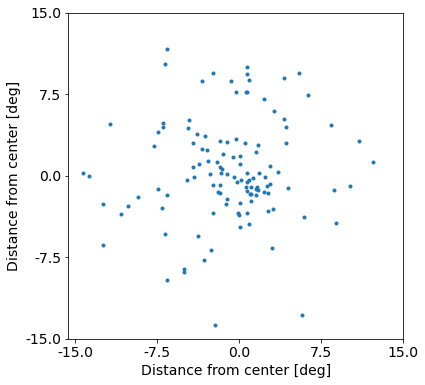

In [24]:
co = np.array(coords)
r = 90-co[:,1]
th = co[:,0]
px = 512

x = ((r * np.cos(th) + 15) * (px/30)).astype(int)
y = ((r * np.sin(th) + 15) * (px/30)).astype(int)

r = np.hypot(x,y)
ind = np.where(r<np.hypot(px,px))[0]
# print(len(r), len(r[ind]))

plt.rcParams.update({'font.size': 14, 'figure.figsize': (6,6)});
plt.plot(x[ind], y[ind],'.');
plt.xticks(np.linspace(0,512,5), np.linspace(-15,15,5));
plt.yticks(np.linspace(0,512,5), np.linspace(-15,15,5));
plt.xlabel('Distance from center [deg]')
plt.ylabel('Distance from center [deg]')

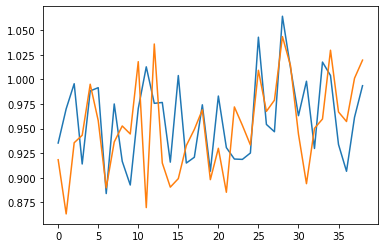

In [18]:
plt.plot(d[:,0,0,0,0:2,0])

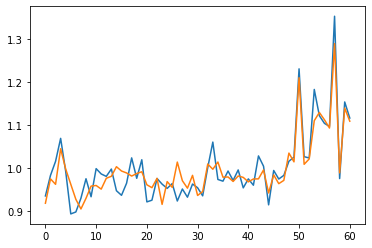

In [17]:
plt.plot(d[0,:,0,0,0:2,0])

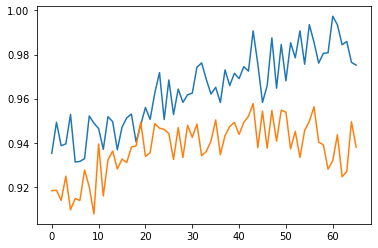

In [19]:
plt.plot(d[0,0,:,0,0:2,0])

In [6]:
################################ MEMORY HEAVY
# create dataset with 122 values

%cd /net/ike/vault-ike/asad/lofar

sols = np.load("data/eff_nr_nodiff.npy") # number of solutions per cluster

c = 0
dde = np.zeros((d.shape[0],d.shape[1],d.shape[2],d.shape[3],len(sols),d.shape[5]))
for i,ii in enumerate(sols):
  dat = []
  for j in range(int(ii)):
    dat.append(d[:,:,:,:,c,:])
    c += 1
  dde[:,:,:,:,i,:] = np.mean(np.array(dat), axis=0)

np.save('data/L90490_122.npy', dde)


/net/ike/vault-ike/asad/lofar


In [25]:
%cd /net/ike/vault-ike/asad/lofar
d = np.load('data/L90490_122.npy')
d = d[:,:,:,:,ind,:]
d = d[...,0] + 1j * d[...,1]
d = np.abs(d)


/net/ike/vault-ike/asad/lofar


In [26]:
px = 512
img = np.zeros((px,px))
img[x[ind],y[ind]] = d[0,0,0,0,:]


In [28]:
Ns = np.arange(1,1002,100)
dcom = []
for i,ii in enumerate(Ns):
  print(ii)
  decom = zernike.decompose(img, ii)
  dcom.append(decom)


1
101
201
301
401
501
601
701
801
901
1001


In [84]:
len(dcom)

11

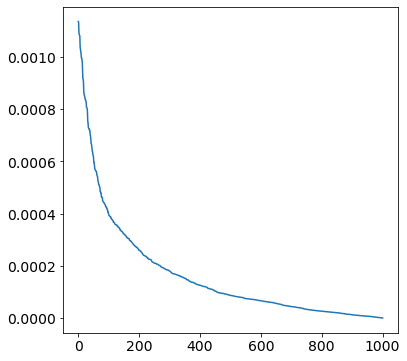

In [29]:
cind = np.argsort(np.abs(dcom[10]))[::-1]
plt.plot(np.abs(dcom)[10][cind])


In [13]:
cind[:30]


array([ 21, 632,  10, 596, 668,  36, 530, 823, 466,  55, 563, 408,   3,
       862, 706, 352, 780, 499, 138, 747, 951, 633, 948, 864, 907, 564,
       407, 742, 106, 745])

In [51]:
data = np.zeros((9,11,7))

np.

(9, 4, 7)

In [30]:
thresholds = np.arange(20,101,20)

recon=[]

for c,coeffs in enumerate(dcom[1:]):
    rec =  []
    for t,T in enumerate(thresholds):
        print(c,T)
        reconstruction = zernike.reconstruct(coeffs, T, img)
        rec.append(reconstruction)
    recon.append(rec)


0 20
0 40
0 60
0 80
0 100
1 20
1 40
1 60
1 80
1 100
2 20
2 40
2 60
2 80
2 100
3 20
3 40
3 60
3 80
3 100
4 20
4 40
4 60
4 80
4 100
5 20
5 40
5 60
5 80
5 100
6 20
6 40
6 60
6 80
6 100
7 20
7 40
7 60
7 80
7 100
8 20
8 40
8 60
8 80
8 100
9 20
9 40
9 60
9 80
9 100


In [34]:
len(recon[0])

5

([<matplotlib.axis.XTick at 0x7fd03c0a9490>,
 <a list of 5 Text major ticklabel objects>)

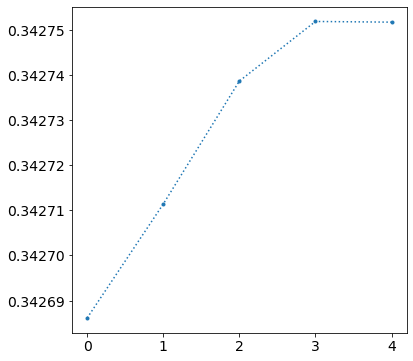

In [38]:
res = [np.std(img[x[ind],y[ind]]-recon[2][i][x[ind],y[ind]]) for i in range(5)]
plt.plot(res, '.:')
plt.xticks(np.arange(5))

Text(0, 0.5, 'Normalized root-mean-square error (NRMSE)')

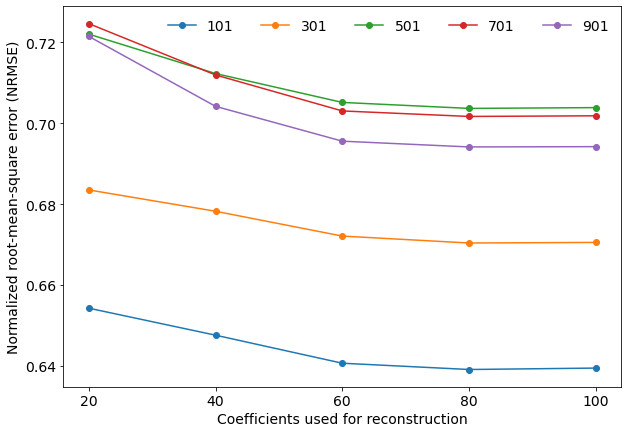

In [83]:
residual = []
dat = img[x[ind],y[ind]]
for c in [1,3,5,7,9]:
    res = []
    for t,T in enumerate(thresholds):
        mod = recon[c][t][x[ind],y[ind]]
        mod = (mod / np.max(mod)) * np.max(dat)
        nrmse = np.sqrt(np.mean((np.abs(dat)-np.abs(mod))**2)) / np.mean(np.abs(dat))
        res.append(nrmse)
    residual.append(res)
    plt.plot(thresholds, res, 'o-', label=len(dcom[c]))

plt.rcParams.update({'font.size': 14, 'figure.figsize': (10,7)});
plt.legend(ncol=5,loc='upper right', frameon=False)
plt.xticks(thresholds)
plt.xlabel('Coefficients used for reconstruction')
plt.ylabel('Normalized root-mean-square error (NRMSE)')


In [144]:
thresholds

array([ 20,  40,  60,  80, 100])

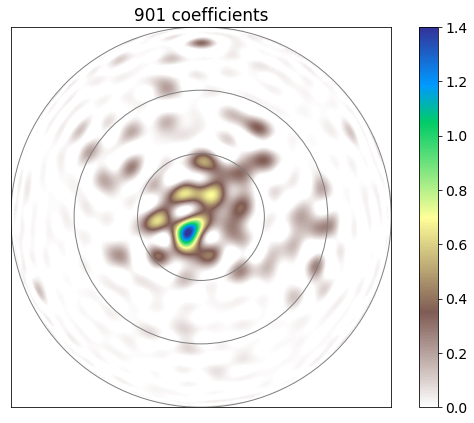

In [143]:
c = 9
mod = recon[c][2]
mod = mod / mod.max() * img.max()

plt.imshow(mod, extent=[-15,15,-15,15], cmap=plt.cm.terrain_r, vmin=0., vmax=1.4)

plt.colorbar()
plt.title("%i coefficients"%len(dcom[c]))
plt.xticks([]); plt.yticks([])

plt.gca().add_patch(plt.Circle((0,0), 5, color='gray', fill=False))
plt.gca().add_patch(plt.Circle((0,0), 10, color='gray', fill=False))
plt.gca().add_patch(plt.Circle((0,0), 15, color='gray', fill=False))


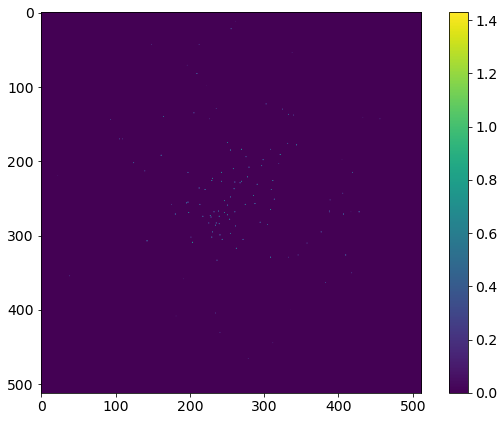

In [77]:
plt.imshow(img)
plt.colorbar()

In [156]:
!pwd

/net/ike/vault-ike/asad/lofar


In [158]:
px = 512
img = np.zeros((px,px))

Cf, Rf = [], []
for i in range(d.shape[2]):
    print(i,)
    img[x[ind],y[ind]] = d[0,0,i,0,:]
    coeff = zernike.decompose(img, 500)
    Cf.append(coeff)
    
np.save('coeffs_freq.npy', np.array(Cf))

print('freq done')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
freq done


In [161]:
Cf = np.array(Cf)

Text(0.5, 0, 'Channel number')

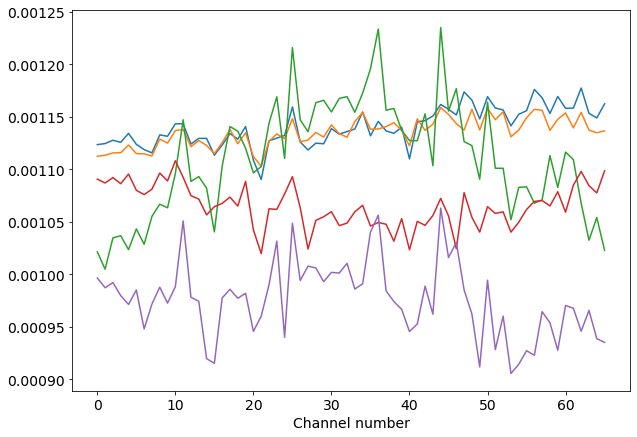

In [173]:
sorti = np.argsort(np.mean(np.abs(Cf), axis=0))[::-1]

plt.plot(abs(Cf[:,sorti[0:5]]))
plt.xlabel('Channel number')


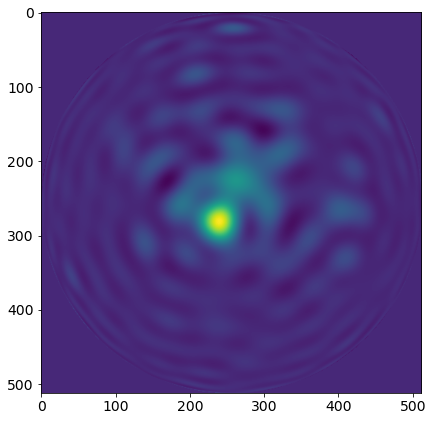

In [154]:
plt.imshow(rec[1])

In [ ]:
px = 512
img = np.zeros((px,px))
coeffs = []
for t in range(d.shape[0]):
    for s in range(d.shape[1]):
        for f in range(d.shape[2]):
            for c in range(d.shape[3]):
    print(i,)
    img[x[ind],y[ind]] = d[0,0,i,0,:]
    dec = zernike.decompose(img, 500)
    rec.append(zernike.reconstruct(dec, 60, img))
